In [105]:
%config InlineBackend.figure_format="svg"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Preprocess data

In [117]:
# Calculate execution time gains for every (totalsize, number of buckets) group
def calculateGains(group):
    for col in metrics:
        oldstd = col + "_std"
        meancol = col + "Gain"
        stdcol = meancol + "_std"
        base = float(group[group["ProcessCount"] == 1][col])
        basestd = float(group[group["ProcessCount"] == 1][oldstd])
        group[meancol] = base / group[col]
        group[stdcol] = np.sqrt( (basestd / group[col])**2 + (base * group[oldstd] / group[col])**2 )
    num_proc = group["ProcessCount"]
    gain = group["TotalTimeGain"]
    group["ParallelFrac"] = num_proc / (1 - num_proc + 1e-8) * (1/gain - 1)
    group["ParallelFrac_std"] = abs(num_proc / (gain**2 * (1-num_proc + 1e-8)) * group["TotalTimeGain_std"])
    return group

In [118]:
# Gather collected data
data = pd.read_csv("results.csv")

# Program parameters and metrics
parameters = ["TotalSize", "NumBuckets", "ProcessCount"]
metrics = ["ProcTime", "MsgTime", "WaitTime", "TotalTime"]

# Get means and stds of all runs
dataMeans = data.groupby(parameters).mean().reset_index()
dataStds = data.groupby(parameters).std().reset_index()

# Add everything to one dataframe
for col in metrics:
    newcol = col + "_std"
    dataMeans[newcol] = dataStds[col]
    
# Group dataframe by totalsize and number of buckets
# This is done to calculate the execution time gains for every of these groups
parameters.pop()
data = dataMeans.groupby(parameters).apply(calculateGains)
parameters.append("ProcessCount")
        
# Gather everything back
del dataMeans
del dataStds

In [119]:
data[data["ProcessCount"] == 12]

,TotalSize,NumBuckets,ProcessCount,ProcTime,MsgTime,WaitTime,TotalTime,ProcTime_std,MsgTime_std,WaitTime_std,...,ProcTimeGain,ProcTimeGain_std,MsgTimeGain,MsgTimeGain_std,WaitTimeGain,WaitTimeGain_std,TotalTimeGain,TotalTimeGain_std,ParallelFrac,ParallelFrac_std
11,200000,1,12,0.005672,0.001022,0.000119,0.006812,0.000704,0.001452,0.000029,...,4.446746,0.137572,0.167662,0.003106,0.000844,2.668589e-03,3.727800,0.114993,0.798268,0.009027
23,200000,2,12,0.005368,0.000978,0.000232,0.006579,0.000402,0.000907,0.000314,...,4.485564,0.115320,0.177794,0.006826,0.000861,1.814273e-03,3.686797,0.094144,0.795013,0.007556
35,200000,3,12,0.005285,0.001364,0.000092,0.006740,0.000317,0.001784,0.000034,...,4.392885,0.129497,0.126833,0.003099,0.001089,3.444747e-03,3.469698,0.101849,0.776499,0.009229
47,200000,4,12,0.005413,0.001433,0.000083,0.006930,0.000657,0.001524,0.000021,...,4.209954,0.114237,0.119112,0.001520,0.002404,5.067753e-03,3.313194,0.089587,0.761647,0.008903
59,200000,5,12,0.005234,0.001281,0.000105,0.006620,0.000362,0.001207,0.000071,...,4.276154,0.062469,0.133313,0.002602,0.000956,3.023210e-03,3.406891,0.049491,0.770702,0.004652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5999,10000000,600,12,0.254306,0.019834,0.003601,0.277742,0.001054,0.002629,0.000592,...,4.395958,0.073824,0.617172,0.018592,0.000555,3.287772e-07,4.069112,0.069165,0.822814,0.004557
6011,10000000,700,12,0.253340,0.019567,0.003869,0.276777,0.001233,0.003087,0.000730,...,4.541397,0.042511,0.631600,0.023629,0.000698,1.248481e-04,4.201509,0.040681,0.831262,0.002514
6023,10000000,800,12,0.252939,0.023540,0.003635,0.280114,0.001332,0.003647,0.000630,...,4.945095,0.192931,0.522466,0.015572,0.000633,1.328954e-04,4.509270,0.174474,0.848983,0.009361
6035,10000000,900,12,0.251544,0.023458,0.003824,0.278826,0.001109,0.002740,0.000422,...,4.412591,0.099296,0.521609,0.015554,0.000549,8.270668e-05,4.024739,0.089626,0.819858,0.006036


# Plotting function

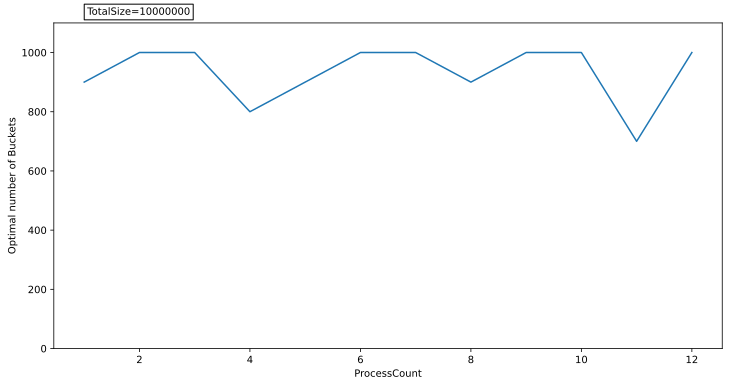

In [164]:
slice_dict = {"TotalSize": 10000000}

def min_buckets(df, slice_dict, xcol, metric, xscale="linear", yscale="linear"):
    # Get df slice according to slice_dict keys and values
    config = ""
    for key in slice_dict: 
        df = df[df[key] == slice_dict[key]]
        config += f"{key}={slice_dict[key]}"
        
    # Get the values to plot
    y = []
    x = np.unique(df[xcol].to_numpy())
    for xs in x:
        new_df = df[df[xcol] == xs]
        y.append(df.loc[new_df[metric].idxmin()]["NumBuckets"])
    y = np.array(y)
    
    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    props = dict(boxstyle='square', facecolor='white')
    ax.text(0.05, 1.025, config, transform=ax.transAxes, fontsize=10, bbox=props)
    ax.plot(x, y)
    ax.set_ylim(0,1100)
    ax.set_xlabel(xcol)
    ax.set_ylabel("Number of Buckets")
    plt.show()
    
min_buckets(data, slice_dict, "ProcessCount", "TotalTime")

In [211]:
from matplotlib import gridspec

def plot(ax, x, y_mean, y_cf, label, linestyle="-", marker="o", color="blue"):
    # Plot the mean
    ax.plot(x, y_mean, label=label, linestyle=linestyle, color=color)
    # Fill between lower and upper confidence intervals
    ax.fill_between(x, y_mean - y_cf, y_mean + y_cf, alpha=0.2, color=color)
    
def plot_slice(df, slice_dict, xcol, ycol, title, conf_interval=1, xscale="linear", yscale="linear", save=False):
    # Get df slice according to slice_dict keys and values
    config = ""
    for key in slice_dict: 
        df = df[df[key] == slice_dict[key]]
        config += f"{key}={slice_dict[key]}\n"
    config += f"Confidence Interval=${conf_interval} \cdot \sigma$"
        
    # Get the values to plot
    x, y_means, y_stds = df[xcol], df[ycol], df[ycol + "_std"]
    y_ci = conf_interval * y_stds / np.sqrt(len(y_stds))
    
    if ycol == "ParallelFrac":
        x = np.delete(np.array(x), [0])
        y_means = np.delete(np.array(y_means), [0])
        y_ci = np.delete(np.array(y_ci), [0])
    
    # Plot data
    props = dict(boxstyle='square', facecolor='white')
    fig = plt.figure(figsize=(12,5))
    if "TotalTimeGain" in ycol: 
        gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
        ax = plt.subplot(gs[0])
        if "Gain" in ycol:
            ax.plot(x,x,label="Ideal", linestyle="--")
            plot(ax, x, y_means, y_ci, label="Measured")
            ax.legend()
        else:
            plot(ax, x, y_means, y_ci, label="")
        ax1 = plt.subplot(gs[1], sharex=ax)
        total = df["TotalTime"]
        y_msg = df["MsgTime"] / total
        y_proc = df["ProcTime"] / total
        y_wait = df["WaitTime"] / total
        width = 2 / len(x)
        ax1.bar(x-width, y_proc, color='darkgreen', label="Proc", width=width)
        ax1.bar(x, y_msg, color='goldenrod', label="Msg", width=width)
        ax1.bar(x+width, y_wait, color='firebrick', label="Wait", width=width)
        ax1.set_ylabel("Time Contribution")
        ax1.set_yscale("linear")
        ax1.set_xscale(xscale)
        ax1.minorticks_on()
        ax1.grid(b=True, which="major", linestyle="-")
        ax1.grid(b=True, which="minor", linestyle="dotted")
        plt.subplots_adjust(hspace=.0)
        ax1.legend()
    else: 
        ax = plt.subplot()
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        plot(ax, x, y_means, y_ci, "")
    ax.set_title(title)
    ax.text(0.8075, 1.025, config, transform=ax.transAxes, fontsize=10, bbox=props)
    plt.xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.minorticks_on()
    ax.grid(b=True, which="major", linestyle="-")
    ax.grid(b=True, which="minor", linestyle="dotted")
    if save: plt.savefig("Plots/" + title.replace(" ","") + ".png", dpi=300)
    plt.show()

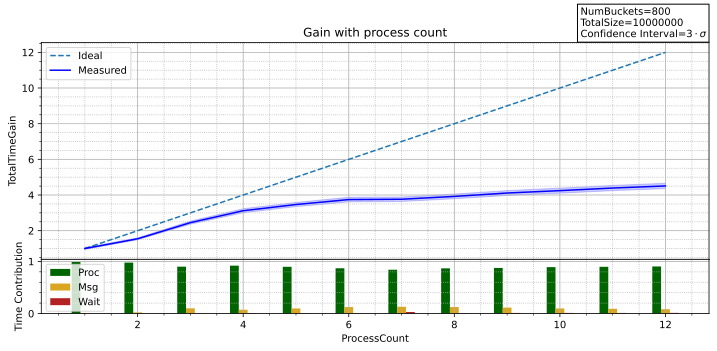

In [212]:
slice_dict = {"NumBuckets": 800, "TotalSize": 10000000}
plot_slice(data, slice_dict, "ProcessCount", "TotalTimeGain", "Gain with process count", 3, save=True, yscale="linear")